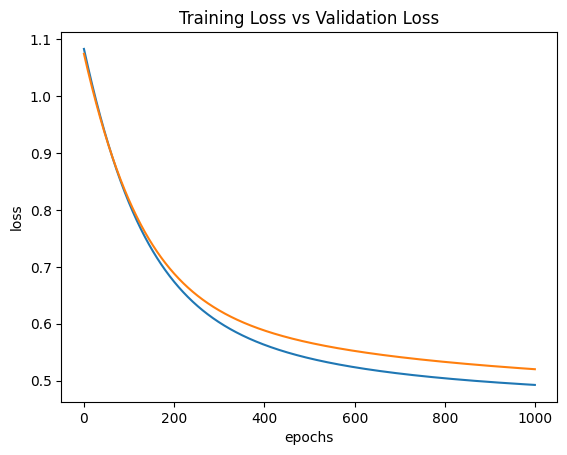

From-Scratch Validation BCE: 0.5200258237241367


In [5]:
# From-Scratch Linear Regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def one_hot_encode(df, column):
    unique = df[column].unique() # find all unique values in the dataset
    unique.sort() # sort them
    index = df.columns.get_loc(column) # get the index of the column
    for val in unique: # loop through the unique values
        name = column + "_" + str(val) # append column and _val
        df.insert(index, name, 0) # insert it
        df.loc[df[column] == val, name] = 1 # boolean mask to set the column value to 1 where applicable
        index += 1 
    return df.drop(column, axis=1) # drop the original column
    
def z_score_normalization(df, column):
    mean = df[column].mean() # calculate the mean and standard deviation
    std = df[column].std()

    name = 'Z_' + column
    index = df.columns.get_loc(column) 
    df.insert(index, name, 0)
    df[name] = (df[column] - mean) / std # set all indexes to the z-score value
    return df.drop(column, axis=1) # drop the original column

def sigmoid(z):
    return 1/(1+np.exp(-z))

def initialize_params(m_features, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    w = np.random.rand(m_features, 1)
    b = 0
    return w, b


def forward(X, w, b):
    # X = m x n
    # w = n x 1
    
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    return z, y_hat

def compute_cost(y, y_hat):
    y_hat = y_hat.reshape(-1, 1)
    y = y.reshape(-1, 1)
    
    cost = -1/len(y) * np.sum(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))  
    return cost
    
def compute_gradients(X, y, y_hat):
    y_hat = y_hat.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # compute dw and db
    n = len(y)
    dw = 1/n * np.dot(X.T, y_hat-y)
    db = 1/n * np.sum(y_hat -  y)

    return dw, db

def update_params(w, b, dw, db, lr):
    w = w - (lr*dw)
    b = b - (lr*db)
    return w, b

def train(X, y, lr, n_epochs, X_val=None, y_val=None):
    w, b = initialize_params(np.shape(X)[1], 425)

    train_costs = []
    val_costs = []
    for x in range(0, n_epochs):
        z, y_hat = forward(X, w, b)

        # compute training cost
        train_cost = compute_cost(y, y_hat)
        train_costs.append(train_cost)

        if X_val is not None and y_val is not None:
            z_val, y_hat_val = forward(X_val, w, b)
            val_cost = compute_cost(y_val, y_hat_val)
            val_costs.append(val_cost)
        
        dw, db = compute_gradients(X, y, y_hat)
        w, b = update_params(w, b, dw, db, lr)

    if X_val is not None and y_val is not None:
        return w, b, train_costs, val_costs
    
    return w, b, train_costs

def predict_proba(X, w, b):
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    return y_hat

# very simple prediction function
def predict(y_hat):
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0
    return y_hat

def split_data(X, y, test_size, seed):
    m = X.shape[0]

    if seed is not None:
        np.random.seed(seed)
    
    permutation = np.random.permutation(m)
    X_shuffled = X[permutation]
    Y_shuffled = y[permutation]

    idx = int((1 - test_size) * m)

    X_train = X_shuffled[:idx]
    y_train = Y_shuffled[:idx]
    X_test = X_shuffled[idx:]
    y_test = Y_shuffled[idx:]
    
    return X_train, y_train, X_test, y_test

train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# data preparation
# we will only use pclass, age, sex, and fare
y = train_data['Survived']
X = train_data.drop(columns=['PassengerId', 'Survived', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'])

X['Age'] = X['Age'].fillna(X['Age'].mean()) # replace null values with mean
X['Fare'] = X['Fare'].fillna(X['Fare'].mean())

X = one_hot_encode(X, "Pclass")
X = one_hot_encode(X, "Sex")
X = z_score_normalization(X, "Age")
X = z_score_normalization(X, "Fare")

test_ids = test_data['PassengerId']
test_data = test_data.drop(columns=['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'])
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].mean())
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].mean())

test_data = one_hot_encode(test_data, "Pclass")
test_data = one_hot_encode(test_data, "Sex")
test_data = z_score_normalization(test_data, "Age")
test_data = z_score_normalization(test_data, "Fare")

# convert dataframe to np arrays
X = X.to_numpy()
y = y.to_numpy()
test_data = test_data.to_numpy()

# split the data
X_train, y_train, X_val, y_val = split_data(X, y, 0.2, 18)

# train the model
w, b, train_costs, val_costs = train(X_train, y_train, 0.01, 1000, X_val, y_val)

# prep the data for plotting
x_train_cost = np.arange(0, len(train_costs))
y_train_cost = np.array(train_costs)
x_val_cost = np.arange(0, len(val_costs))
y_val_cost = np.array(val_costs)

# plot training vs validation loss
plt.plot(x_train_cost, y_train_cost)
plt.plot(x_val_cost, y_val_cost)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss vs Validation Loss')
plt.show()

# calculate the BCE
y_val_proba = predict_proba(X_val, w, b)
val_bce = compute_cost(y_val, y_val_proba)
print("From-Scratch Validation BCE:", val_bce)

predictions = predict(predict_proba(test_data, w, b)).flatten()
predictions = predictions.astype(int)
# print(predictions)
submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': predictions})
filename = 'Titanic-Submission.csv'
submission.to_csv(filename, index=False)

# print(submission)



